# Evaluating Automated Stopping

## Setup 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from openTSNE import TSNE
import openTSNE
import time
import json
from math import ceil

# for local imports  
from pathlib import Path
import sys
import os 

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

figures_dir = Path.cwd().parent / "figures"
sys.path.append(str(figures_dir))

results_dir = Path.cwd().parent / "results"
sys.path.append(str(results_dir))

import datasets
import quality_measures

2025-03-08 10:06:26.671545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Functions 

### KLD and KLDRC Monitor

In [19]:
from openTSNE import callbacks 
class KLDMonitor(callbacks.Callback):
    def __init__(self, record_every=5):
        self.record_every = record_every
        self.kl_divergences = {}
    
    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence while ensuring unique iteration values.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            # in this case we are in the embedding phase  
            if iteration in self.kl_divergences or iteration > 250:
                self.kl_divergences[iteration + 250] = error 
            # in the EE phase     
            else: 
                self.kl_divergences[iteration] = error

In [4]:
buffer_ee = 15
switch_buffer = 2 

class KLDRCMonitorEE(callbacks.Callback):
    def __init__(self, record_every=3):
        """
        Parameters:
            record_every (int): Check KL divergence every this many iterations.
            buffer_ee (int): Minimum iterations before monitoring KL divergence.
            switch_buffer (int): Extra iterations to confirm EE phase exit.
        """
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_ee = 3`
        self.kl_divergences = []
        self.rel_changes = [] # this should be a list with entries (iteration, rel_change)
        self.last_error = None
        self.last_rel_change = None
        self.switch_buffer_count = switch_buffer  # Tracks remaining iterations before exiting EE

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence and determines when to stop Early Exaggeration.
        Returns True if EE should stop.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

            if self.last_error is not None:
                # Compute relative change: (prev_error - current_error) / prev_error
                rel_change = 100 * (self.last_error - error) / self.last_error  
                self.rel_changes.append((iteration, rel_change))

                print(f"Iteration {iteration}: KL Divergence = {error:.4f}, Relative Change = {rel_change:.4f}%")

                # Start checking only after `buffer_ee` iterations
                if iteration > buffer_ee:
                    if self.last_rel_change is not None and rel_change < self.last_rel_change:
                        # If relative change decreases, start the switch buffer countdown
                        if self.switch_buffer_count < 1:
                            print("Relative change has consistently decreased. Stopping Early Exaggeration.")
                            print(f"EE Iteration stopped at {iteration}")
                            # Signal to stop EE phase, we return iteration as well 
                            return True, iteration  
                        self.switch_buffer_count -= 1
                    else:
                        # Reset switch buffer if relative change increases again
                        self.switch_buffer_count = switch_buffer

                self.last_rel_change = rel_change

            # Update last error for the next iteration
            self.last_error = error

        return False  # Continue EE phase if conditions are not met

In [5]:
buffer_run = 150 
auto_iter_end = 100 

class KLDRCMonitorRun(callbacks.Callback):
    def __init__(self, record_every=5):
        """
        Parameters:
            record_every (int): Check KL divergence every this many iterations.
            buffer_run (int): Minimum iterations after EE before monitoring for stopping.
            auto_iter_end (float): Threshold for stopping, lower values stop earlier.
        """
        self.record_every = record_every  # Equivalent to `auto_iter_pollrate_run = 5`
        # self.buffer_run = buffer_run  # Equivalent to `auto_iter_buffer_run = 15`
        # self.auto_iter_end = auto_iter_end  # Used for stopping condition

        self.kl_divergences = []
        self.last_error = None

    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence and determines when to stop the full t-SNE run.
        Returns True if the run should stop.
        """
        # Only check KL divergence every `record_every` iterations
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))

            if self.last_error is not None:
                # Compute absolute error difference
                error_diff = abs(self.last_error - error)

                print(f"Iteration {iteration}: KL Divergence = {error:.4f}, Error Diff = {error_diff:.6f}")

                # Start monitoring only after `buffer_run` iterations have passed
                if iteration > buffer_run:
                    # Stopping condition from C++: abs(error_diff)/pollrate < error/auto_iter_end
                    if (error_diff / self.record_every) < (error / auto_iter_end):
                        print("KL divergence change is below threshold. Stopping optimization.")
                        print(f"Run iteration stopped at {iteration}")
                        return True, iteration  # Signal to stop t-SNE run

            # Update last error
            self.last_error = error

        return False  # Continue t-SNE run


### Running t-SNE

In [21]:
def run_optSNE(data, labels, random_state):
    """
    Runs the optimized t-SNE (i.e. with automated stopping) on a given dataset.
    This version accepts data and labels as inputs (instead of using a global DataFrame).
    
    Returns:
      embedding: the final embedding.
      final_kld: final KL divergence value.
      labels: the labels (unchanged).
      kld_monitor: the monitor object containing the KL divergence history.
    """
    # In this version we use the entire dataset.
    features = data  # assuming data is already a numpy array
    
    initiali = openTSNE.initialization.pca(features, random_state=random_state)
    
    # using default perplexity
    affinities = openTSNE.affinity.PerplexityBasedNN(
        features,
        perplexity=30, 
        n_jobs=-1,
        random_state=random_state,
        verbose=True
    )
    
    embedding_obj = openTSNE.TSNEEmbedding(
        initiali, 
        affinities, 
        random_state=random_state,
        verbose=True
    )
    
    # --- Early Exaggeration phase ---
    kld_monitor_EE = KLDRCMonitorEE(record_every=3)
    try:
        embedding_obj = embedding_obj.optimize(
            n_iter=1000, 
            callbacks=kld_monitor_EE, 
            callbacks_every_iters=3, 
            verbose=True
        )
    except Exception as e:
        print("Early Exaggeration phase stopped early:", e)

    # extract results 
    ee_kld = kld_monitor_EE.kl_divergences 
    ee_rel = kld_monitor_EE.rel_changes 
    ee_offset = ee_kld[-1][0] if ee_kld else 0
    
    # --- Embedding phase ---
    kld_tracker_embed = KLDRCMonitorRun(record_every=5)
    try:
        embedding_obj = embedding_obj.optimize(
            n_iter=1000,
            callbacks=kld_tracker_embed, 
            callbacks_every_iters=5, 
            verbose=True
        )
    except Exception as e:
        print("Embedding phase stopped early:", e)

    # kld offset for plotting reasons
    run_kld = [(iteration + ee_offset, error) for (iteration, error) in kld_tracker_embed.kl_divergences]
    combined_kld = ee_kld + run_kld
        
    monitor_data = {
        "kl_divergences": combined_kld,
        "rel_changes": ee_rel
    }
    return embedding_obj, labels, monitor_data

In [7]:
def run_tsne_experiments(datasets, seeds, default_EE=250, verbose=False):
    """
    Runs both normal t-SNE and optimized t-SNE (opt-SNE) on each dataset,
    each with multiple seeds.
    
    Parameters:
      datasets: list of tuples (data, labels)
      seeds: list of seeds (e.g., 3 seeds)
      default_EE: fixed early exaggeration iterations for normal t-SNE
      verbose: verbosity flag
      
    Returns:
      embeddings: dict with keys ((dataset_index, setting), seed) mapping to 
                  (embedding, labels, kld_history)
      timings: list of dicts with timing info.
    """
    embeddings = {}
    timings = []
    
    for d_idx, (data, labels) in enumerate(datasets):
        if hasattr(data, "values"):
            data = data.values.astype(float)

        for seed in seeds:
            # --- Run normal t-SNE with default settings ---
            # using normal kld monitor
            kld_monitor_norm = KLDMonitor()  
            tsne_norm = TSNE(early_exaggeration_iter=default_EE, 
                             n_iter=750 - default_EE, 
                             n_jobs=-1,
                             callbacks=kld_monitor_norm, 
                             callbacks_every_iters=5,
                             random_state=seed, 
                             verbose=verbose)
            t0 = time.time()
            embedding_norm = tsne_norm.fit(data)
            elapsed_normal = time.time() - t0
            kld_norm = kld_monitor_norm.kl_divergences
            embeddings[((d_idx, "normal"), seed)] = (embedding_norm, labels, kld_norm)
            timings.append({
                "dataset_index": d_idx, 
                "setting": "normal", 
                "seed": seed, 
                "time_taken_seconds": elapsed_normal
            })
            
            # --- Run optimized t-SNE (opt-SNE) ---
            t0 = time.time()
            embedding_opt, labels_opt, monitor_data = run_optSNE(
                data, labels, random_state=seed)
            elapsed_opt = time.time() - t0
        
            embeddings[((d_idx, "opt"), seed)] = (embedding_opt, labels_opt, monitor_data)
            timings.append({
                "dataset_index": d_idx, 
                "setting": "opt", 
                "seed": seed, 
                "time_taken_seconds": elapsed_opt
            })
            
    # Optionally, save timings to a file.
    save_path = os.path.join(results_dir, "opt-SNE_times.json")
    with open(save_path, "w") as f:
        json.dump(timings, f, indent=4)
        
    return embeddings

### Embedding Grid Plotting

In [ ]:
def plot_embedding_grid_experiments(embeddings, seeds, dataset_ids, file_start="opt-SNE", cmap="tab20"):
    """
    Plots a grid of t-SNE embeddings from experiments.
    Rows correspond to seeds and columns correspond to each (dataset, setting) combination.
    Column order: for each dataset, first "normal" then "opt".
    
    Parameters:
      embeddings (dict): Dictionary with keys ((dataset_index, setting), seed) mapping to 
                         (embedding, labels, kld_history).
      seeds (list): List of seeds used.
      dataset_ids (list): List of dataset indices or names (hashable).
      file_start (str): Prefix for the saved filename.
      cmap (str): Colormap to use.
    """
    # Build column parameter list: one entry per (dataset, setting) combination.
    column_parameters = []
    for d in dataset_ids:
        column_parameters.append((d, "normal"))
        column_parameters.append((d, "opt"))
        
    row_parameters = seeds  # each row is one seed
    n_rows = len(row_parameters)
    n_cols = len(column_parameters)
    
    subplot_size = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, subplot_size * n_rows), squeeze=False)
    # fig.suptitle("t-SNE Embeddings", fontsize=12)
    
    for r_idx, seed in enumerate(row_parameters):
        for c_idx, col in enumerate(column_parameters):
            ax = axes[r_idx, c_idx]
            key = (col, seed)
            if key not in embeddings:
                ax.axis("off")
                continue
            embedding, labels, _ = embeddings[key]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=2, alpha=0.6)
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)
            # For the top row, add a title showing dataset and setting.
            if r_idx == 0:
                d_idx, setting = col
                ax.set_title(f"{setting}", fontsize=12, pad=10)
            # For the left-most column, add a label showing the seed.
            #if c_idx == 0:
            #    ax.set_ylabel(f"Seed: {seed}", fontsize=12, labelpad=10)
                
    plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)
    save_path = os.path.join(figures_dir, f"{file_start}_embedding_grid_{cmap}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### Plot Quality Measures (without KLD)

In [9]:
def plot_quality_measures(quality_results, dataset_names, plot_name="ee_length", x_axis_label="EE length", x_axis_entries=None):
    """
    Plots three side-by-side plots for the three embedding quality measures.

    Parameters:
        quality_results (dict): Maps x-axis entries to dataset indices with tuples (mnn, mnn_global, rho).
        dataset_names (dict): Maps dataset indices to dataset names.
        plot_name (str): For saving the file, e.g. "perp", "n_iter" etc.
        x_axis_label (str): Label for the x-axis.
        x_axis_entries (list): Custom x-axis entries; defaults to sorted keys of quality_results (this should be okay).
    """
    if x_axis_entries is None:
        x_axis_entries = list(quality_results.keys())

    dataset_indices = sorted(next(iter(quality_results.values())).keys())  # Extract dataset indices
    dataset_data = {d: {'mnn': [], 'mnn_global': [], 'rho': []} for d in dataset_indices}

    # Extract data
    for x in x_axis_entries:
        for d in dataset_indices:
            mnn, mnn_global, rho = quality_results[x][d]
            dataset_data[d]['mnn'].append(mnn)
            dataset_data[d]['mnn_global'].append(mnn_global)
            dataset_data[d]['rho'].append(rho)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["KNN", "KNC", "CPD"]

    for i, (metric, title) in enumerate(zip(['mnn', 'mnn_global', 'rho'], titles)):
        for d, data in dataset_data.items():
            axes[i].plot(x_axis_entries, data[metric], marker='o', linestyle='-', label=dataset_names.get(d, f"{d}"))
        axes[i].set_title(title, fontsize=12)
        axes[i].set_xlabel(x_axis_label, fontsize=12)

    # Formatting
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_linewidth(0.5)

    axes[0].legend(fontsize=10)  # Only first plot has legend
    plt.tight_layout()

    # Save & Show
    save_path = os.path.join(figures_dir, f"{plot_name}_3_quality_measures.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### Plot KL Divergences

In [11]:
def plot_kld_monitors_grid_experiments(embeddings, datasets, seed_for_kld=1, file_start="kld_opt", mode="opt"):
    """
    Plots, for each dataset, the KL divergence and relative change curves (from opt-SNE)
    for a specified seed (default seed 1), arranged in a single row (one subplot per dataset).
    
    Parameters:
      embeddings (dict): Dictionary with keys ((dataset_index, setting), seed) mapping to 
                         (embedding, labels, kld_history).
      datasets (list): List of dataset indices.
      seed_for_kld: The seed to use for plotting (default 1).
      file_start (str): Prefix for file saving.
      mode (str): Which setting to use (e.g. "opt").
    """
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(12, 4))
    if n_datasets == 1:
        axes = [axes]
    
    for i, d in enumerate(datasets):
        key = ((d, mode), seed_for_kld)
        if key not in embeddings:
            axes[i].axis("off")
            continue
        # Assume kld_history is a list of tuples.
        # For this plot we assume each tuple is (iteration, kld_error, relative_change).
        _, _, kld_history = embeddings[key]
        iterations, kld_values, rel_changes = [], [], []
        for record in kld_history:
            # If the record has three entries, unpack iteration, error, rel_change.
            if len(record) >= 3:
                it, err, rel = record[:3]
            else:
                it, err = record[:2]
                rel = 0  # or compute relative change if desired
            iterations.append(it)
            kld_values.append(err)
            rel_changes.append(rel)
        # Plot both curves.
        axes[i].plot(iterations, kld_values, linestyle='-', marker='', color='blue', label="KLD")
        axes[i].plot(iterations, rel_changes, linestyle='-', marker='', color='red', label="Rel Change")
        axes[i].set_xlabel("Iteration", fontsize=12)
        axes[i].set_ylabel("Value", fontsize=12)
        axes[i].set_title(f"Dataset {d} (opt, seed {seed_for_kld})", fontsize=12)
        axes[i].spines["top"].set_visible(False)
        axes[i].spines["right"].set_visible(False)
        axes[i].tick_params(axis="both", which="major", labelsize=10, width=0.5)
        axes[i].tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        if i == 0:
            axes[i].legend(fontsize=10)
    plt.tight_layout()
    save_path = os.path.join(figures_dir, f"{file_start}_kl_divergences_grid.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

In [12]:
def plot_kl_divergences_grid(embedding_dict, file_start):
    """
    Plots averaged KL divergence curves (in this case, single-run curves) for each learning rate,
    separately for each dataset in a 2x2 grid.

    For each dataset:
      - Extracts the KL divergence records (a dict mapping iteration -> error) for each learning rate.
      - Sorts the learning rates (numeric ones first, then any non-numeric).
      - Plots the KL divergence curve for each learning rate with the legend label using the Greek letter η.
    
    Parameters:
      embedding_dict (dict): Dictionary with keys (η, dataset_index) mapping to 
                             (embedding, labels, kld_values) where kld_values is a dict mapping iteration -> error.
      file_start (str): e.g eta, ee etc.
    """

    # Determine unique dataset indices.
    datasets = sorted({ds for (_, ds) in embedding_dict.keys()})
    
    # Optional: map dataset indices to names.
    dataset_names = {0: "Iris", 1: "Macosko", 2: "MNIST", 3: "Flow18"}
    
    # Create a 2x2 grid of subplots.
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Loop over each dataset to plot its KL divergence curves.
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        
        # Collect learning rates for this dataset.
        ee_factors = [alpha for (alpha, ds) in embedding_dict.keys() if ds == dataset]
        # Order learning rates: numeric first (sorted), then any non-numeric - this isn't strictly necessary
        #numeric_lrs = sorted([eta for eta in lrs if isinstance(eta, (int, float))])
        #non_numeric_lrs = [eta for eta in lrs if not isinstance(eta, (int, float))]
        #ordered_lrs = numeric_lrs + non_numeric_lrs
        
        # Plot each learning rate's KL divergence curve.
        for alpha in ee_factors:
            _, _, kld_values = embedding_dict[(alpha, dataset)]
            # Sort iterations and get corresponding error values.
            iterations = sorted(kld_values.keys())
            errors = [kld_values[it] for it in iterations]
            ax.plot(iterations, errors, linestyle='-', label=f"EE length = {alpha}")
        
        # Format the subplot.
        ax.set_xlabel("Iteration", fontsize=12)
        ax.set_ylabel("KL Divergence", fontsize=12)
        title = dataset_names.get(dataset, str(dataset))
        ax.set_title(title, fontsize=12)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        
        if idx==0: 
          ax.legend(fontsize=10)
    
    # Hide any unused subplots (if fewer than 4 datasets).
    for j in range(len(datasets), len(axes)):
        axes[j].axis("off")
    
    # Adjust spacing between subplots.
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Save and display the figure.
    save_path = os.path.join(figures_dir, f"{file_start}_kl_divergences_grid.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### Quality Plotting for Different Seeds

In [13]:
def average_quality_measures(embedding_dict, X, ee_lengths):
    """
    Computes the average quality measures across different seeds for each learning rate
    and stores individual seed results.

    Parameters:
        embedding_dict (dict): Dictionary with (ee_iter, seed) as keys and
                               (embedding, labels, kld_values) as values.
        X (numpy.ndarray): Original high-dimensional data.

    Returns:
        dict: Dictionary with learning_rate as keys and values being another dictionary:
              {
                  "average": (mnn_avg, mnn_global_avg, rho_avg),
                  "seeds": {seed: (mnn, mnn_global, rho), ...}
              }
    """
    quality_results = {}

    for ee_len in ee_lengths:
        mnn_list, mnn_global_list, rho_list = [], [], []
        seed_results = {}

        for seed in [key[1] for key in embedding_dict.keys() if key[0] == ee_len]:
            # Unpack three elements; ignore kld_values
            embedding, labels, _ = embedding_dict[(ee_len, seed)]
            mnn, mnn_global, rho = quality_measures.embedding_quality(X, embedding, labels)

            mnn_list.append(mnn)
            mnn_global_list.append(mnn_global)
            rho_list.append(rho)

            # Store per-seed results
            seed_results[seed] = (mnn, mnn_global, rho)

        # Compute averages
        quality_results[ee_len] = {
            "average": (
                np.mean(mnn_list),
                np.mean(mnn_global_list),
                np.mean(rho_list)
            ),
            "seeds": seed_results
        }

    return quality_results


In [14]:
def plot_quality_measures_seeds(quality_results, x_axis_label="EE length", plot_name="ee_length_seeds"):
    """
    Plots three side-by-side plots for the three embedding quality measures.
    Includes individual seed results as connected grey lines and averaged results in black.

    Parameters:
        quality_results (dict): Dictionary with ee_length as keys and values being another dictionary:
                                {
                                    "average": (mnn_avg, mnn_global_avg, rho_avg),
                                    "seeds": {seed: (mnn, mnn_global, rho), ...}
                                }
        x_axis_label (str): Label for the x-axis (default "EE length").
        plot_name (str): Name for saving the file.
        figures_dir (str): Directory where the plot will be saved.
    """

    # Get sorted EE lengths and create x-axis labels.
    ee_lengths = sorted(quality_results.keys())
    ee_labels = [str(x) for x in ee_lengths]

    # Prepare averaged data for plotting.
    mnn_values = [quality_results[x]["average"][0] for x in ee_lengths]
    mnn_global_values = [quality_results[x]["average"][1] for x in ee_lengths]
    rho_values = [quality_results[x]["average"][2] for x in ee_lengths]

    # Prepare per-seed data: For each seed, collect quality measures across EE lengths.
    seed_data = {}  # key: seed, value: dict with lists for each measure.
    for x in ee_lengths:
        seed_results = quality_results[x]["seeds"]
        for seed, (mnn, mnn_global, rho) in seed_results.items():
            if seed not in seed_data:
                seed_data[seed] = {'mnn': [], 'mnn_global': [], 'rho': []}
            seed_data[seed]['mnn'].append(mnn)
            seed_data[seed]['mnn_global'].append(mnn_global)
            seed_data[seed]['rho'].append(rho)

    # Create the 1x3 subplot layout.
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["KNN", "KNC", "CPD"]

    # Plot per-seed results (grey lines) for each quality measure.
    for seed, data in seed_data.items():
        axes[0].plot(ee_labels, data['mnn'], linestyle='-', color='grey', alpha=0.5)
        axes[1].plot(ee_labels, data['mnn_global'], linestyle='-', color='grey', alpha=0.5)
        axes[2].plot(ee_labels, data['rho'], linestyle='-', color='grey', alpha=0.5)

    # Plot averaged results (black with markers) for each quality measure.
    axes[0].plot(ee_labels, mnn_values, marker='o', linestyle='-', color='black', label="Average")
    axes[1].plot(ee_labels, mnn_global_values, marker='o', linestyle='-', color='black', label="Average")
    axes[2].plot(ee_labels, rho_values, marker='o', linestyle='-', color='black', label="Average")

    # Set x-axis and y-axis labels.
    for ax in axes:
        ax.set_xlabel(x_axis_label, fontsize=12)
    #axes[0].set_ylabel("KNN", fontsize=12)
    #axes[1].set_ylabel("KNC", fontsize=12)
    #axes[2].set_ylabel("CPD", fontsize=12)

    # Set subplot titles.
    for i, title in enumerate(titles):
        axes[i].set_title(title, fontsize=12)

    # Formatting: remove top/right spines and adjust tick parameters.
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=10, width=0.5)
        ax.tick_params(axis="both", which="minor", labelsize=8, width=0.3)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_linewidth(0.5)

    # Only include legend in the first plot.
    axes[0].legend(fontsize=10)

    plt.tight_layout()

    # Save and display the figure.
    save_path = os.path.join(figures_dir, f"{plot_name}_3_quality_measures.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


## Experiments

In [15]:
all_data = datasets.load_all_datasets()

In [16]:
# for testing a smaller number of datapoints 
n_points = 200
all_data = [datasets.load_n_samples(n_points, X, y) for (X, y) in all_data[1:]]

In [17]:
seeds = [1, 12, 42]

In [22]:
embeddings_dict = run_tsne_experiments(all_data, seeds=seeds) 

===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 1000 iterations...
Iteration 6: KL Divergence = 1.6114, Relative Change = -0.2111%
Iteration 9: KL Divergence = 1.3224, Relative Change = 17.9322%
Iteration 12: KL Divergence = 0.7190, Relative Change = 45.6279%
Iteration 15: KL Divergence = 0.4734, Relative Change = 34.1643%
Iteration 18: KL Divergence = 0.4025, Relative Change = 14.9805%
Iteration 21: KL Divergence = 0.3805, Relative Change = 5.4597%
Iteration 24: KL Divergence = 0.3672, Relative Change = 3.4864%
Relative change has consistently decreased. Stopping Early Exaggeration.
EE Iteration stopped at 24
===> Running optimization with exaggeration=1.00, lr=200.00 for 1000 iterations...
Iteration 10: KL Divergence = 0.3506, Error Diff = 0.006374
Iteration 15: KL Divergence = 0.3462, 

In [ ]:
embedding_opt, labels_opt, monitor_data = embeddings_dict[((0, "opt"), 1)]

In [ ]:
kld_opt = monitor_data["kl_divergences"]    
rel_changes = monitor_data["rel_changes"]     

# Print the values:
print("KL Divergences (Iteration, Value):")
for iteration, kld_value in kld_opt:
    print(f"Iteration {iteration}: {kld_value}")

print("\nKL Divergence Relative Changes (Iteration, Value):")
for iteration, rel_change in rel_changes:
    print(f"Iteration {iteration}: {rel_change}")

KL Divergences (Iteration, Value):
Iteration 3: 1.6079962199176752
Iteration 6: 1.6113907656585376
Iteration 9: 1.322432435558424
Iteration 12: 0.7190336896022629
Iteration 15: 0.473380544627636
Iteration 18: 0.40246576535513157
Iteration 21: 0.3804921785248423
Iteration 24: 0.3672265175758662
Iteration 29: 0.3570147693079111
Iteration 34: 0.3506412262075367
Iteration 39: 0.3462271269759558
Iteration 44: 0.3441015183438685
Iteration 49: 0.3430746331324306
Iteration 54: 0.342046282878008
Iteration 59: 0.3418538223090728
Iteration 64: 0.3411755483566674
Iteration 69: 0.34025732153077826
Iteration 74: 0.3394142574024608
Iteration 79: 0.3391280773745944
Iteration 84: 0.33854963257214266
Iteration 89: 0.33829287734261104
Iteration 94: 0.33771560026788805
Iteration 99: 0.33771744039818063
Iteration 104: 0.3373654077081323
Iteration 109: 0.3373460362891594
Iteration 114: 0.33767755257701637
Iteration 119: 0.3373090252516384
Iteration 124: 0.33664722472556097
Iteration 129: 0.33647796898469284

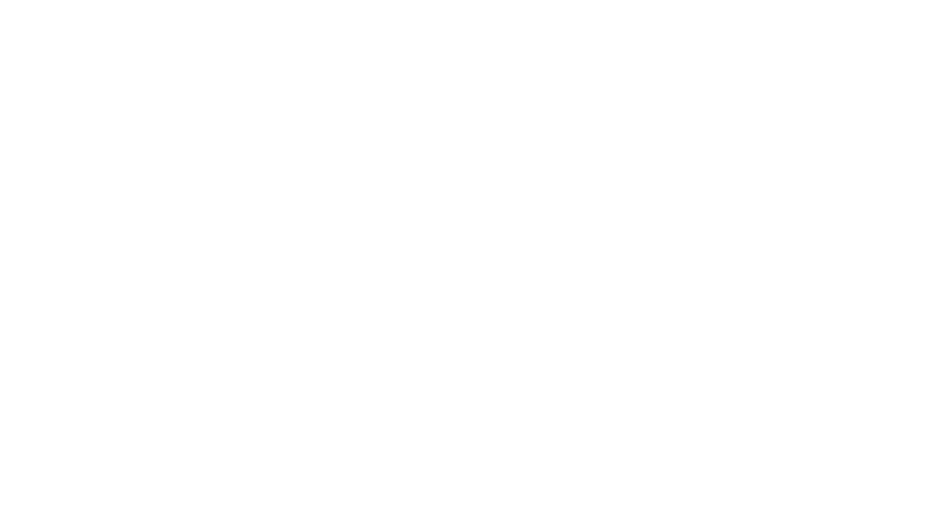

In [35]:
plot_embedding_grid_experiments(embeddings_dict, seeds, [0,1,2], cmap="tab20b")